In [175]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [158]:
train_raw = pd.read_csv('../data/raw//train.csv') #学習データ
test_raw = pd.read_csv('../data/raw/test.csv') #テストデータ
print('The size of the train data:' + str(train_raw.shape))
print('The size of the test data:' + str(test_raw.shape))

train_mid = train_raw.copy()
test_mid = test_raw.copy()
train_mid['train_or_test'] = 'train' #学習データフラグ
test_mid['train_or_test'] = 'test' #テストデータフラグ
test_mid['Survived'] = 9 #テストにSurvivedカラムを仮置き

alldata = pd.concat(
    [
        train_mid,
        test_mid
    ],
    sort=False,
    axis=0
).reset_index(drop=True)
print('The size of the alldata data:' + str(alldata.shape))

The size of the train data:(891, 12)
The size of the test data:(418, 11)
The size of the alldata data:(1309, 13)


# 前処理

## 欠損値補完

In [159]:
# 欠損値補完
alldata.isnull().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                1
Cabin            1014
Embarked            2
train_or_test       0
dtype: int64

In [160]:
# Embarkedには最頻値を代入
alldata.Embarked.fillna(alldata.Embarked.mode()[0], inplace=True)
# Fareには中央値を代入
alldata.Fare.fillna(alldata.Fare.median(), inplace=True)
# 欠損値補完がされたかを確認
print(alldata.isnull().sum())

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age               263
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin            1014
Embarked            0
train_or_test       0
dtype: int64


## 特徴量別加工

### Ticket

In [161]:
# Ticket頻度
alldata.loc[:, 'TicketFreq'] = alldata.groupby(['Ticket'])['PassengerId'].transform('count')

### Name

In [162]:
# テストデータの敬称(honorific)を抽出
alldata['honorific'] = alldata['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
# 敬称(honorific)の加工
alldata['honorific'].replace(['Col','Dr', 'Rev'], 'Rare',inplace=True) #少数派の敬称を統合
alldata['honorific'].replace('Mlle', 'Miss',inplace=True) #Missに統合
alldata['honorific'].replace('Ms', 'Miss',inplace=True) #Missに統合

### Fare

In [163]:
# Fareの分割
alldata.loc[:, 'Fare_bin'] = pd.qcut(alldata.Fare, 14)

### Parch/Sibsp

In [164]:
# Familysize
alldata['FamilySize'] = alldata['Parch'] + alldata['SibSp'] + 1 #ALLデータ
# FamilySizeを離散化
alldata['FamilySize_bin'] = 'big'
alldata.loc[alldata['FamilySize']==1,'FamilySize_bin'] = 'alone'
alldata.loc[(alldata['FamilySize']>=2) & (alldata['FamilySize']<=4),'FamilySize_bin'] = 'small'
alldata.loc[(alldata['FamilySize']>=5) & (alldata['FamilySize']<=7),'FamilySize_bin'] = 'mediam'

### Cabin

In [165]:
# Cabinの頭文字
alldata['Cabin_ini'] = alldata['Cabin'].map(lambda x:str(x)[0])
alldata['Cabin_ini'].replace(['G','T'], 'Rare',inplace=True) #少数派のCabin_iniを統合

## エンコーディング

In [166]:
alldata.dtypes

PassengerId          int64
Survived             int64
Pclass               int64
Name                object
Sex                 object
Age                float64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked            object
train_or_test       object
TicketFreq           int64
honorific           object
Fare_bin          category
FamilySize           int64
FamilySize_bin      object
Cabin_ini           object
dtype: object

In [167]:
# PclassをObject型に変換
alldata.Pclass = alldata.Pclass.astype('str')

In [168]:
# カテゴリ特徴量についてラベルエンコーディング
le_target_col = ['Sex', 'Fare_bin']
le = LabelEncoder()
for col in le_target_col:
    alldata.loc[:, col] = le.fit_transform(alldata[col])

In [169]:
# # カテゴリカル変数
cat_col = ['Pclass', 'Embarked','honorific','Cabin_ini', 'FamilySize_bin', 'Fare_bin']
alldata = pd.get_dummies(alldata, drop_first=True, columns=cat_col)

In [170]:
alldata.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'train_or_test', 'TicketFreq', 'FamilySize',
       'Pclass_2', 'Pclass_3', 'Embarked_Q', 'Embarked_S', 'honorific_Don',
       'honorific_Dona', 'honorific_Jonkheer', 'honorific_Lady',
       'honorific_Major', 'honorific_Master', 'honorific_Miss',
       'honorific_Mme', 'honorific_Mr', 'honorific_Mrs', 'honorific_Rare',
       'honorific_Sir', 'honorific_the Countess', 'Cabin_ini_B', 'Cabin_ini_C',
       'Cabin_ini_D', 'Cabin_ini_E', 'Cabin_ini_F', 'Cabin_ini_Rare',
       'Cabin_ini_n', 'FamilySize_bin_big', 'FamilySize_bin_mediam',
       'FamilySize_bin_small', 'Fare_bin_1', 'Fare_bin_2', 'Fare_bin_3',
       'Fare_bin_4', 'Fare_bin_5', 'Fare_bin_6', 'Fare_bin_7', 'Fare_bin_8',
       'Fare_bin_9', 'Fare_bin_10', 'Fare_bin_11', 'Fare_bin_12',
       'Fare_bin_13'],
      dtype='object')

# モデル構築

In [171]:
from sklearn.model_selection import train_test_split

# 最初に統合したtrainとtestを分離
train = alldata.query('train_or_test == "train"')
test = alldata.query('train_or_test == "test"')
# ターゲット変数と、学習に不要なカラムを定義
target_col = 'Survived'
drop_col = ['PassengerId','Survived', 'Name', 'Fare', 'Ticket', 'Cabin', 'train_or_test', 'Age', 'Parch', 'FamilySize', 'SibSp']
# 学習に必要な特徴量のみを保持
train_feature = train.drop(columns=drop_col)
test_feature = test.drop(columns=drop_col)
train_tagert = train[target_col]
# trainデータを分割
X_train, X_test, y_train, y_test = train_test_split(
    train_feature, train_tagert, test_size=0.2, random_state=0, stratify=train_tagert)

## ベースライン

In [172]:
# trainから頻度に応じて単純なモデルを作る場合
survive_rate = y_train.sum()/len(y_train)
print(f'survive rate:{survive_rate}')
print(f'base line accuracy: {1 - survive_rate}')

survive rate:0.38342696629213485
base line accuracy: 0.6165730337078652


In [173]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
print('='*20)
print('RandomForestClassifier')
print(f'accuracy of train set: {rfc.score(X_train, y_train)}')
print(f'accuracy of test set: {rfc.score(X_test, y_test)}')

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)
print('='*20)
print('XGBClassifier')
print(f'accuracy of train set: {xgb.score(X_train, y_train)}')
print(f'accuracy of train set: {xgb.score(X_test, y_test)}')

lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train, y_train)
print('='*20)
print('LGBMClassifier')
print(f'accuracy of train set: {lgb.score(X_train, y_train)}')
print(f'accuracy of train set: {lgb.score(X_test, y_test)}')

lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
print('='*20)
print('LogisticRegression')
print(f'accuracy of train set: {lr.score(X_train, y_train)}')
print(f'accuracy of train set: {lr.score(X_test, y_test)}')

svc = SVC(random_state=0)
svc.fit(X_train, y_train)
print('='*20)
print('SVC')
print(f'accuracy of train set: {svc.score(X_train, y_train)}')
print(f'accuracy of train set: {svc.score(X_test, y_test)}')

RandomForestClassifier
accuracy of train set: 0.9199438202247191
accuracy of test set: 0.7821229050279329
XGBClassifier
accuracy of train set: 0.8778089887640449
accuracy of train set: 0.7932960893854749
LGBMClassifier
accuracy of train set: 0.8932584269662921
accuracy of train set: 0.7988826815642458
LogisticRegression
accuracy of train set: 0.8426966292134831
accuracy of train set: 0.8156424581005587
SVC
accuracy of train set: 0.8426966292134831
accuracy of train set: 0.8156424581005587


Text(0.5, 1.0, 'RandomForestClassifier feature importance')

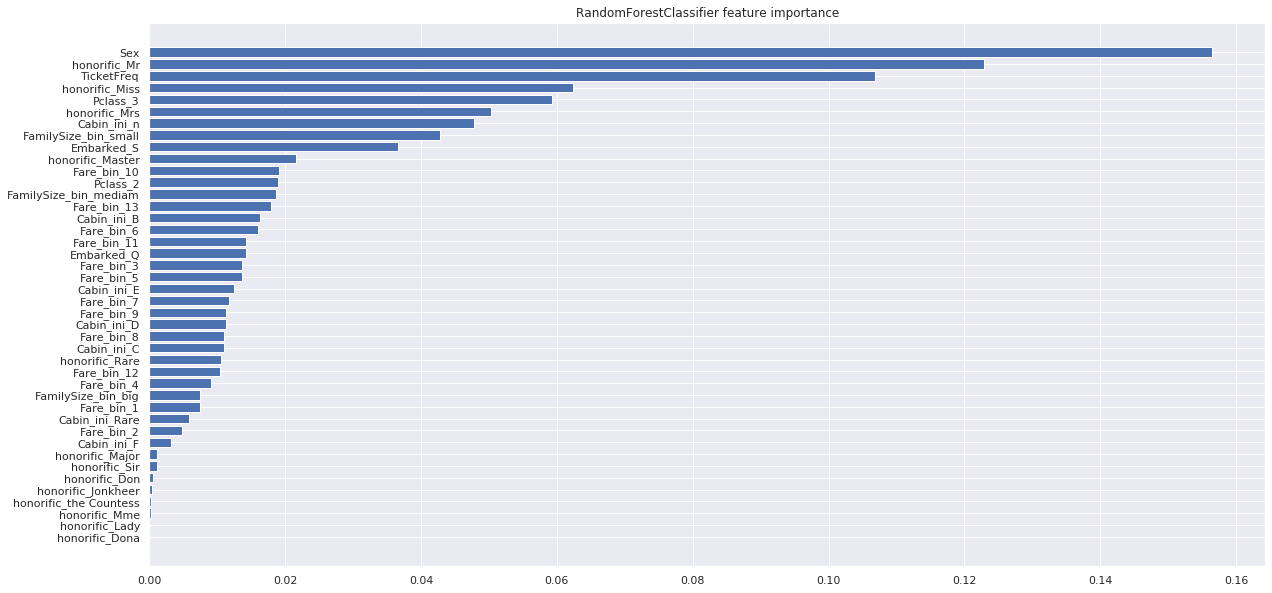

In [174]:
# 試しにRandamForestClassifierの重要度を可視化する
plt.figure(figsize=(20,10))
plt.barh(
    X_train.columns[np.argsort(rfc.feature_importances_)],
    rfc.feature_importances_[np.argsort(rfc.feature_importances_)],
    label='RandomForestClassifier'
)
plt.title('RandomForestClassifier feature importance')

## パラメータチューニング

In [177]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import optuna

# CV分割数
cv = 5

In [185]:
def objective(trial):
    
    param_grid_rfc = {
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        'min_samples_split': trial.suggest_int("min_samples_split", 7, 15),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'max_features': trial.suggest_int("max_features", 3, 10),
        "random_state": 0
    }

    model = RandomForestClassifier(**param_grid_rfc)
    
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_params)
print(study.best_value)
rfc_best_param = study.best_params

[I 2020-01-21 20:40:13,829] Finished trial#0 resulted in value: 0.8328671328671329. Current best value is 0.8328671328671329 with parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 14, 'criterion': 'gini', 'max_features': 6}.
[I 2020-01-21 20:40:14,691] Finished trial#1 resulted in value: 0.8272628779671033. Current best value is 0.8328671328671329 with parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 14, 'criterion': 'gini', 'max_features': 6}.
[I 2020-01-21 20:40:15,589] Finished trial#2 resulted in value: 0.8272431793558553. Current best value is 0.8328671328671329 with parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 14, 'criterion': 'gini', 'max_features': 6}.
[I 2020-01-21 20:40:16,562] Finished trial#3 resulted in value: 0.8342657342657344. Current best value is 0.8342657342657344 with parameters: {'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 11, 'criterion': 'entropy', 'max_features': 9}.
[I 2

{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 8, 'criterion': 'gini', 'max_features': 8}
0.8455037919826653


In [179]:
def objective(trial):
    
    param_grid_xgb = {
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 5),
        'gamma': trial.suggest_discrete_uniform("gamma", 0.1, 1.0, 0.1),
        'subsample': trial.suggest_discrete_uniform("subsample", 0.5, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform("colsample_bytree", 0.5, 1.0, 0.1),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        "random_state": 0
    }

    model = XGBClassifier(**param_grid_xgb)
    
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_params)
print(study.best_value)
xgb_best_param = study.best_params

[I 2020-01-21 20:38:00,054] Finished trial#0 resulted in value: 0.8258741258741258. Current best value is 0.8258741258741258 with parameters: {'min_child_weight': 2, 'gamma': 0.7000000000000001, 'subsample': 0.5, 'colsample_bytree': 0.8, 'max_depth': 9}.
[I 2020-01-21 20:38:00,572] Finished trial#1 resulted in value: 0.8090515118684133. Current best value is 0.8258741258741258 with parameters: {'min_child_weight': 2, 'gamma': 0.7000000000000001, 'subsample': 0.5, 'colsample_bytree': 0.8, 'max_depth': 9}.
[I 2020-01-21 20:38:00,913] Finished trial#2 resulted in value: 0.8160839160839162. Current best value is 0.8258741258741258 with parameters: {'min_child_weight': 2, 'gamma': 0.7000000000000001, 'subsample': 0.5, 'colsample_bytree': 0.8, 'max_depth': 9}.
[I 2020-01-21 20:38:01,352] Finished trial#3 resulted in value: 0.83006993006993. Current best value is 0.83006993006993 with parameters: {'min_child_weight': 2, 'gamma': 0.2, 'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 5}.

{'min_child_weight': 2, 'gamma': 0.30000000000000004, 'subsample': 0.8, 'colsample_bytree': 0.8, 'max_depth': 3}
0.8371121835910568


In [180]:
def objective(trial):
    
    param_grid_lgb = {
        'num_leaves': trial.suggest_int("num_leaves", 3, 10),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1.0),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        "random_state": 0
    }

    model = LGBMClassifier(**param_grid_lgb)
    
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_params)
print(study.best_value)
lgb_best_param = study.best_params

[I 2020-01-21 20:38:50,165] Finished trial#0 resulted in value: 0.783709248497981. Current best value is 0.783709248497981 with parameters: {'num_leaves': 5, 'learning_rate': 0.0037628985606424307, 'max_depth': 6}.
[I 2020-01-21 20:38:50,377] Finished trial#1 resulted in value: 0.6165763813651137. Current best value is 0.783709248497981 with parameters: {'num_leaves': 5, 'learning_rate': 0.0037628985606424307, 'max_depth': 6}.
[I 2020-01-21 20:38:50,605] Finished trial#2 resulted in value: 0.8314882300797795. Current best value is 0.8314882300797795 with parameters: {'num_leaves': 7, 'learning_rate': 0.02862826175870242, 'max_depth': 3}.
[I 2020-01-21 20:38:50,856] Finished trial#3 resulted in value: 0.8174135723431497. Current best value is 0.8314882300797795 with parameters: {'num_leaves': 7, 'learning_rate': 0.02862826175870242, 'max_depth': 3}.
[I 2020-01-21 20:38:51,062] Finished trial#4 resulted in value: 0.6165763813651137. Current best value is 0.8314882300797795 with parameter

{'num_leaves': 7, 'learning_rate': 0.013244610270097636, 'max_depth': 5}
0.8385107849896581


In [181]:
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    
    param_grid_lr = {
        'C' : trial.suggest_int("C", 1, 100),
        "random_state": 0
    }

    model = LogisticRegression(**param_grid_lr)
    
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(study.best_params)
print(study.best_value)
lr_best_param = study.best_params

[I 2020-01-21 20:39:15,806] Finished trial#0 resulted in value: 0.821638924455826. Current best value is 0.821638924455826 with parameters: {'C': 69}.
[I 2020-01-21 20:39:16,207] Finished trial#1 resulted in value: 0.8286713286713286. Current best value is 0.8286713286713286 with parameters: {'C': 12}.
[I 2020-01-21 20:39:16,611] Finished trial#2 resulted in value: 0.8230375258544272. Current best value is 0.8286713286713286 with parameters: {'C': 12}.
[I 2020-01-21 20:39:17,349] Finished trial#3 resulted in value: 0.8286614793657048. Current best value is 0.8286713286713286 with parameters: {'C': 12}.
[I 2020-01-21 20:39:18,156] Finished trial#4 resulted in value: 0.8342657342657344. Current best value is 0.8342657342657344 with parameters: {'C': 3}.
[I 2020-01-21 20:39:18,757] Finished trial#5 resulted in value: 0.8244558258642766. Current best value is 0.8342657342657344 with parameters: {'C': 3}.
[I 2020-01-21 20:39:19,269] Finished trial#6 resulted in value: 0.8230375258544272. Cu

{'C': 3}
0.8342657342657344


In [182]:
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    
    param_grid_svc = {
        'C' : trial.suggest_int("C", 50, 200),
        'gamma': trial.suggest_loguniform("gamma", 1e-4, 1.0),
        "random_state": 0,
        'kernel': 'rbf'
    }

    model = SVC(**param_grid_svc)
    
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(study.best_params)
print(study.best_value)
svc_best_param = study.best_params

[I 2020-01-21 20:39:21,286] Finished trial#0 resulted in value: 0.8342952821826062. Current best value is 0.8342952821826062 with parameters: {'C': 168, 'gamma': 0.0002607742807017676}.
[I 2020-01-21 20:39:21,484] Finished trial#1 resulted in value: 0.8146557667684429. Current best value is 0.8342952821826062 with parameters: {'C': 168, 'gamma': 0.0002607742807017676}.
[I 2020-01-21 20:39:21,678] Finished trial#2 resulted in value: 0.8174431202600217. Current best value is 0.8342952821826062 with parameters: {'C': 168, 'gamma': 0.0002607742807017676}.
[I 2020-01-21 20:39:21,872] Finished trial#3 resulted in value: 0.8399290849995076. Current best value is 0.8399290849995076 with parameters: {'C': 137, 'gamma': 0.008196864738463544}.
[I 2020-01-21 20:39:22,104] Finished trial#4 resulted in value: 0.8385107849896581. Current best value is 0.8399290849995076 with parameters: {'C': 137, 'gamma': 0.008196864738463544}.
[I 2020-01-21 20:39:22,294] Finished trial#5 resulted in value: 0.823027

{'C': 137, 'gamma': 0.008196864738463544}
0.8399290849995076


### 汎化性能検証

In [186]:
# 5-Fold CV / Accuracy でモデルを評価する
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

rfc_best = RandomForestClassifier(**rfc_best_param)
print('RandomForestClassifier')
print('='*20)
scores = cross_validate(rfc_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

xgb_best = XGBClassifier(**xgb_best_param)
print('XGBClassifier')
print('='*20)
scores = cross_validate(xgb_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

lgb_best = LGBMClassifier(**lgb_best_param)
print('LGBMClassifier')
print('='*20)
scores = cross_validate(lgb_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

lr_best = LogisticRegression(**lr_best_param)
print('LogisticRegression')
print('='*20)
scores = cross_validate(lr_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

svc_best = SVC(**svc_best_param)
print('SVC')
print('='*20)
scores = cross_validate(svc_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

RandomForestClassifier
mean:0.8260247316552632, std:0.014793329171865436
XGBClassifier
mean:0.8091896302805852, std:0.01754044707039134
LGBMClassifier
mean:0.8192706044818279, std:0.03411615247033993
LogisticRegression
mean:0.8204004770573097, std:0.023470908532220384
SVC
mean:0.8158998179649739, std:0.025691782403221345


In [187]:
from sklearn.ensemble import VotingClassifier

# voting に使う分類器を用意する
estimators = [
    ('rfc', RandomForestClassifier(**rfc_best_param)),
    ('xgb', XGBClassifier(**xgb_best_param)),
    ('lgb', LGBMClassifier(**lgb_best_param)),
    ('lr', LogisticRegression(**lr_best_param)),
    ('svc', SVC(**lr_best_param))
]
voting = VotingClassifier(estimators)

print('VotingClassifier')
print('='*20)
scores = cross_validate(voting, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')

VotingClassifier
mean:0.823758709434436, std:0.02340554802689898


# 推論

In [195]:
# RandomForest
rfc_best = RandomForestClassifier(**rfc_best_param)
rfc_best.fit(train_feature, train_tagert)
# XGBoost
xgb_best = XGBClassifier(**xgb_best_param)
xgb_best.fit(train_feature, train_tagert)
# LightGBM
lgb_best = LGBMClassifier(**lgb_best_param)
lgb_best.fit(train_feature, train_tagert)
# LogisticRegression
lr_best = LogisticRegression(**lr_best_param)
lr_best.fit(train_feature, train_tagert)
# SVC
svc_best = SVC(**svc_best_param)
svc_best.fit(train_feature, train_tagert)
# 推論
pred = {
    'rfc': rfc_best.predict(test_feature),
    'xgb': xgb_best.predict(test_feature),
    'lgb': lgb_best.predict(test_feature),
    'lr': lr_best.predict(test_feature),
    'svc': svc_best.predict(test_feature)
}
# ファイル出力
for key, value in pred.items():
    pd.concat(
        [
            pd.DataFrame(test.PassengerId, columns=['PassengerId']).reset_index(drop=True),
            pd.DataFrame(value, columns=['Survived'])
        ],
        axis=1
    ).to_csv(f'output_{key}.csv', index=False)